In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

from minimal.imaging import draw_plan
from minimal.gen import run_model

%matplotlib inline

In [3]:
from minimal import sample_graphs

from pregen.premade import premade_graphs
from pregen import signature as sg

In [13]:
# sg.find_closest_graph(sample_graphs.two()).draw()

In [12]:
# sample_graphs.two().draw()

In [32]:
# g = premade_graphs[40]
# masks = run_model(g, num_iters=10)
# draw_plan(masks, g.node_types)

In [33]:
gi = 40
g = premade_graphs[gi]

In [6]:
NUM_MAPS = 10
results = []
for i in range(NUM_MAPS):
    masks = run_model(g, num_iters=10)
    results.append(masks)

print("Done")

Done


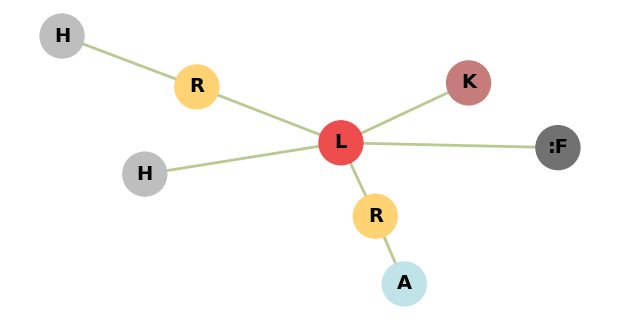

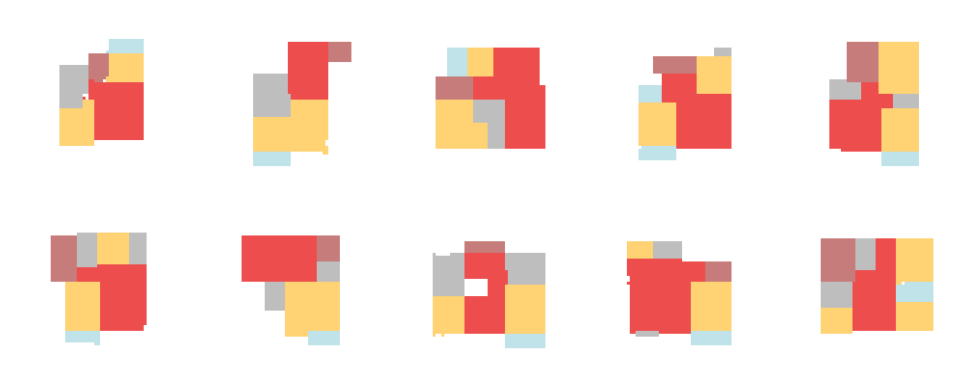

In [34]:
gi = 40
g = premade_graphs[gi]
plt.figure(figsize=(6,3))
g.draw()

_, axes = plt.subplots(2,5, figsize=(10, 4), gridspec_kw={'wspace': 0, 'hspace': 0})
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(draw_plan(results[i], g.node_types))
plt.tight_layout()